In [1]:
# import libs
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.sql.functions import col
import datetime
from pyspark.sql import Row
import csv

In [2]:
# load dataset
df = spark.read.csv(
    "data/k66-summarize.csv", header=True, mode="DROPMALFORMED"
)
df.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  k| AA| AB| AC| AD| AE| AF| AG| AH| AI| AJ| AK| AL| AM| AN| AO| AP| AQ| AR| AS| AT| AU| AV|  AW| AX| AY| AZ| BA| BB| BC| BD| BE| BF| BG| BH| BI| BJ| BK| BL| BM| BN| BO| BP| BQ| BR| BS| BT| BU| BV| BW| BX| BY| BZ| CA| CC| CD| CE| CF| CG| CH| CI| CJ| CK| CL| CM| CN|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0| 15|  9|  3| 10|  2|  7| 11|  5| 19|  9|  7| 11| 12| 24|  3|  2|  3|  9| 12| 13|773|  5|   8|  7|  4| 13|  7|  5| 11| 11|  5|  5|  8|  6|  5|  6| 10| 11| 13|795|  9|  3|  3|  6| 11|  7|  5| 10| 

In [3]:
cols = df.columns[1:]
df = df.select(col('k').cast("string").alias('k'),*(col(c).cast("int").alias(c) for c in cols))
df.dtypes

[('k', 'string'),
 ('AA', 'int'),
 ('AB', 'int'),
 ('AC', 'int'),
 ('AD', 'int'),
 ('AE', 'int'),
 ('AF', 'int'),
 ('AG', 'int'),
 ('AH', 'int'),
 ('AI', 'int'),
 ('AJ', 'int'),
 ('AK', 'int'),
 ('AL', 'int'),
 ('AM', 'int'),
 ('AN', 'int'),
 ('AO', 'int'),
 ('AP', 'int'),
 ('AQ', 'int'),
 ('AR', 'int'),
 ('AS', 'int'),
 ('AT', 'int'),
 ('AU', 'int'),
 ('AV', 'int'),
 ('AW', 'int'),
 ('AX', 'int'),
 ('AY', 'int'),
 ('AZ', 'int'),
 ('BA', 'int'),
 ('BB', 'int'),
 ('BC', 'int'),
 ('BD', 'int'),
 ('BE', 'int'),
 ('BF', 'int'),
 ('BG', 'int'),
 ('BH', 'int'),
 ('BI', 'int'),
 ('BJ', 'int'),
 ('BK', 'int'),
 ('BL', 'int'),
 ('BM', 'int'),
 ('BN', 'int'),
 ('BO', 'int'),
 ('BP', 'int'),
 ('BQ', 'int'),
 ('BR', 'int'),
 ('BS', 'int'),
 ('BT', 'int'),
 ('BU', 'int'),
 ('BV', 'int'),
 ('BW', 'int'),
 ('BX', 'int'),
 ('BY', 'int'),
 ('BZ', 'int'),
 ('CA', 'int'),
 ('CC', 'int'),
 ('CD', 'int'),
 ('CE', 'int'),
 ('CF', 'int'),
 ('CG', 'int'),
 ('CH', 'int'),
 ('CI', 'int'),
 ('CJ', 'int'),
 ('CK'

In [4]:
k = df.select('k').rdd.map(lambda x: x[0]).collect()
values = []
for c in cols:
    values.append(np.array(df.select(c).rdd.map(lambda r: r[0]).collect()))
len(values)

65

In [5]:
values

[array([ 15,  13,   3,   5,   7,   3,   4,   0,   1,   3,  10,   1,   4,
          7,  15,  13,   2,   5,   1,   0,  12,   0,   5,   5,  18,   0,
          8,   9,   1,  10,   3,   2,   6,   0,   3,   1,   2, 166,  16,
          4,   6,   3,   2,   5,   0,  14,   0,   1,   7,   6,   3,   4,
         16,   3,   1,   7,   4,   3,   4,   2,   5,   4,   7,   2,   9,
          8]),
 array([  9,   5,   6,  12,  12,   7,  14,   0,   7,   0,   9,   1,   3,
          3,   9,   9,   9,   4,   8,   0,  23,   0,   5,   3,   0,   1,
          4,   8,   1,  12,   2,   8,  15,   0,   5,   7,   5, 669,  19,
          6,  12,   8,   6,   7,   0,   9,   3,   2,  11,   9,   7,   3,
         10,  12,   0,  16,   6,   4,   7,   0,   8,  14,  11,  11,  13,
          8]),
 array([  3,   8,   4, 781,   5,  11,   2,   0,   4,   2,  18,   0,   3,
          6,   8,   6,   7,   9,  10,   0,  11,   2,   5,   5,   1,   1,
         10,   6,   1,   7,   5,   4,   4,   1,   6,  13,   6,   2,   7,
          7,   2,  10

In [6]:
def validColor(color, colors):
    for c in colors:
        exist = True
        if (((np.round(c,1)==np.round(color,1)).all()) == False):
            exist = False
        if (exist == True):
#             print('exists!!!')
            return False
        print(c)
    return True

In [9]:
colors = []
for i in range(len(values)):
    print(i)
    color = np.random.rand(3)
    while validColor(color, colors) == False:
        color = np.random.rand(4)
    colors.append(color)
colors


0
1
[0.23759215 0.60687746 0.89407097]
2
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
3
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
4
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
[0.23347145 0.8591361  0.77529069]
5
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
[0.23347145 0.8591361  0.77529069]
[0.48168994 0.0599913  0.99908463]
6
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
[0.23347145 0.8591361  0.77529069]
[0.48168994 0.0599913  0.99908463]
[0.05207283 0.42170869 0.79157922]
7
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
[0.23347145 0.8591361  0.77529069]
[0.48168994 0.0599913  0.99908463]
[0.05207283 0.42170869 0.79157922]
[0.12499276 0.37496006 0.38123688]
8
[0

[0.91650354 0.8852098  0.16764914]
[0.5273131  0.53505811 0.99337486]
[0.77548616 0.02146198 0.76185643]
[0.62250481 0.60474052 0.98354044]
[0.99693938 0.5936761  0.4141773 ]
[0.82659063 0.01548958 0.36580781]
[0.98110658 0.36022828 0.77974863]
[0.9794109  0.09096028 0.58192922]
[0.13323466 0.44408932 0.04228334]
[0.36557715 0.33405624 0.09794199]
[0.1596249  0.24575901 0.41004284]
[0.90323945 0.54668473 0.87785545]
[0.5457055  0.99878111 0.58005142]
[0.3630057  0.96236742 0.30931227]
[0.02080438 0.24617517 0.47498063]
[0.86767732 0.65904507 0.23021582]
[0.07989151 0.42583762 0.18106346]
[0.07494357 0.99274071 0.82202375]
[0.30150628 0.90041174 0.15421017]
[0.92654833 0.34592312 0.04018742]
[0.4444985  0.34445684 0.67908644]
[0.62594694 0.73390018 0.97883551]
[0.01165968 0.835716   0.98596002]
41
[0.23759215 0.60687746 0.89407097]
[0.06457781 0.17720711 0.50453768]
[0.3703206  0.32546606 0.39910204]
[0.23347145 0.8591361  0.77529069]
[0.48168994 0.0599913  0.99908463]
[0.05207283 0.421

[0.41106208 0.46147106 0.52398749]
[0.97913801 0.18542594 0.97480858]
[0.82588954 0.56324522 0.60121058]
[0.42777457 0.28204184 0.62558145]
[0.2015425  0.58786294 0.77105669]
[0.8078379  0.3566292  0.81816634]
[0.98079507 0.68977148 0.00259942]
[0.91650354 0.8852098  0.16764914]
[0.5273131  0.53505811 0.99337486]
[0.77548616 0.02146198 0.76185643]
[0.62250481 0.60474052 0.98354044]
[0.99693938 0.5936761  0.4141773 ]
[0.82659063 0.01548958 0.36580781]
[0.98110658 0.36022828 0.77974863]
[0.9794109  0.09096028 0.58192922]
[0.13323466 0.44408932 0.04228334]
[0.36557715 0.33405624 0.09794199]
[0.1596249  0.24575901 0.41004284]
[0.90323945 0.54668473 0.87785545]
[0.5457055  0.99878111 0.58005142]
[0.3630057  0.96236742 0.30931227]
[0.02080438 0.24617517 0.47498063]
[0.86767732 0.65904507 0.23021582]
[0.07989151 0.42583762 0.18106346]
[0.07494357 0.99274071 0.82202375]
[0.30150628 0.90041174 0.15421017]
[0.92654833 0.34592312 0.04018742]
[0.4444985  0.34445684 0.67908644]
[0.62594694 0.733900

[array([0.23759215, 0.60687746, 0.89407097]),
 array([0.06457781, 0.17720711, 0.50453768]),
 array([0.3703206 , 0.32546606, 0.39910204]),
 array([0.23347145, 0.8591361 , 0.77529069]),
 array([0.48168994, 0.0599913 , 0.99908463]),
 array([0.05207283, 0.42170869, 0.79157922]),
 array([0.12499276, 0.37496006, 0.38123688]),
 array([0.26788648, 0.88166851, 0.62606708]),
 array([0.16257133, 0.65561465, 0.05193123]),
 array([0.8696086 , 0.36384121, 0.84150693]),
 array([0.41106208, 0.46147106, 0.52398749]),
 array([0.97913801, 0.18542594, 0.97480858]),
 array([0.82588954, 0.56324522, 0.60121058]),
 array([0.42777457, 0.28204184, 0.62558145]),
 array([0.2015425 , 0.58786294, 0.77105669]),
 array([0.8078379 , 0.3566292 , 0.81816634]),
 array([0.98079507, 0.68977148, 0.00259942]),
 array([0.91650354, 0.8852098 , 0.16764914]),
 array([0.5273131 , 0.53505811, 0.99337486]),
 array([0.77548616, 0.02146198, 0.76185643]),
 array([0.62250481, 0.60474052, 0.98354044]),
 array([0.99693938, 0.5936761 , 0.

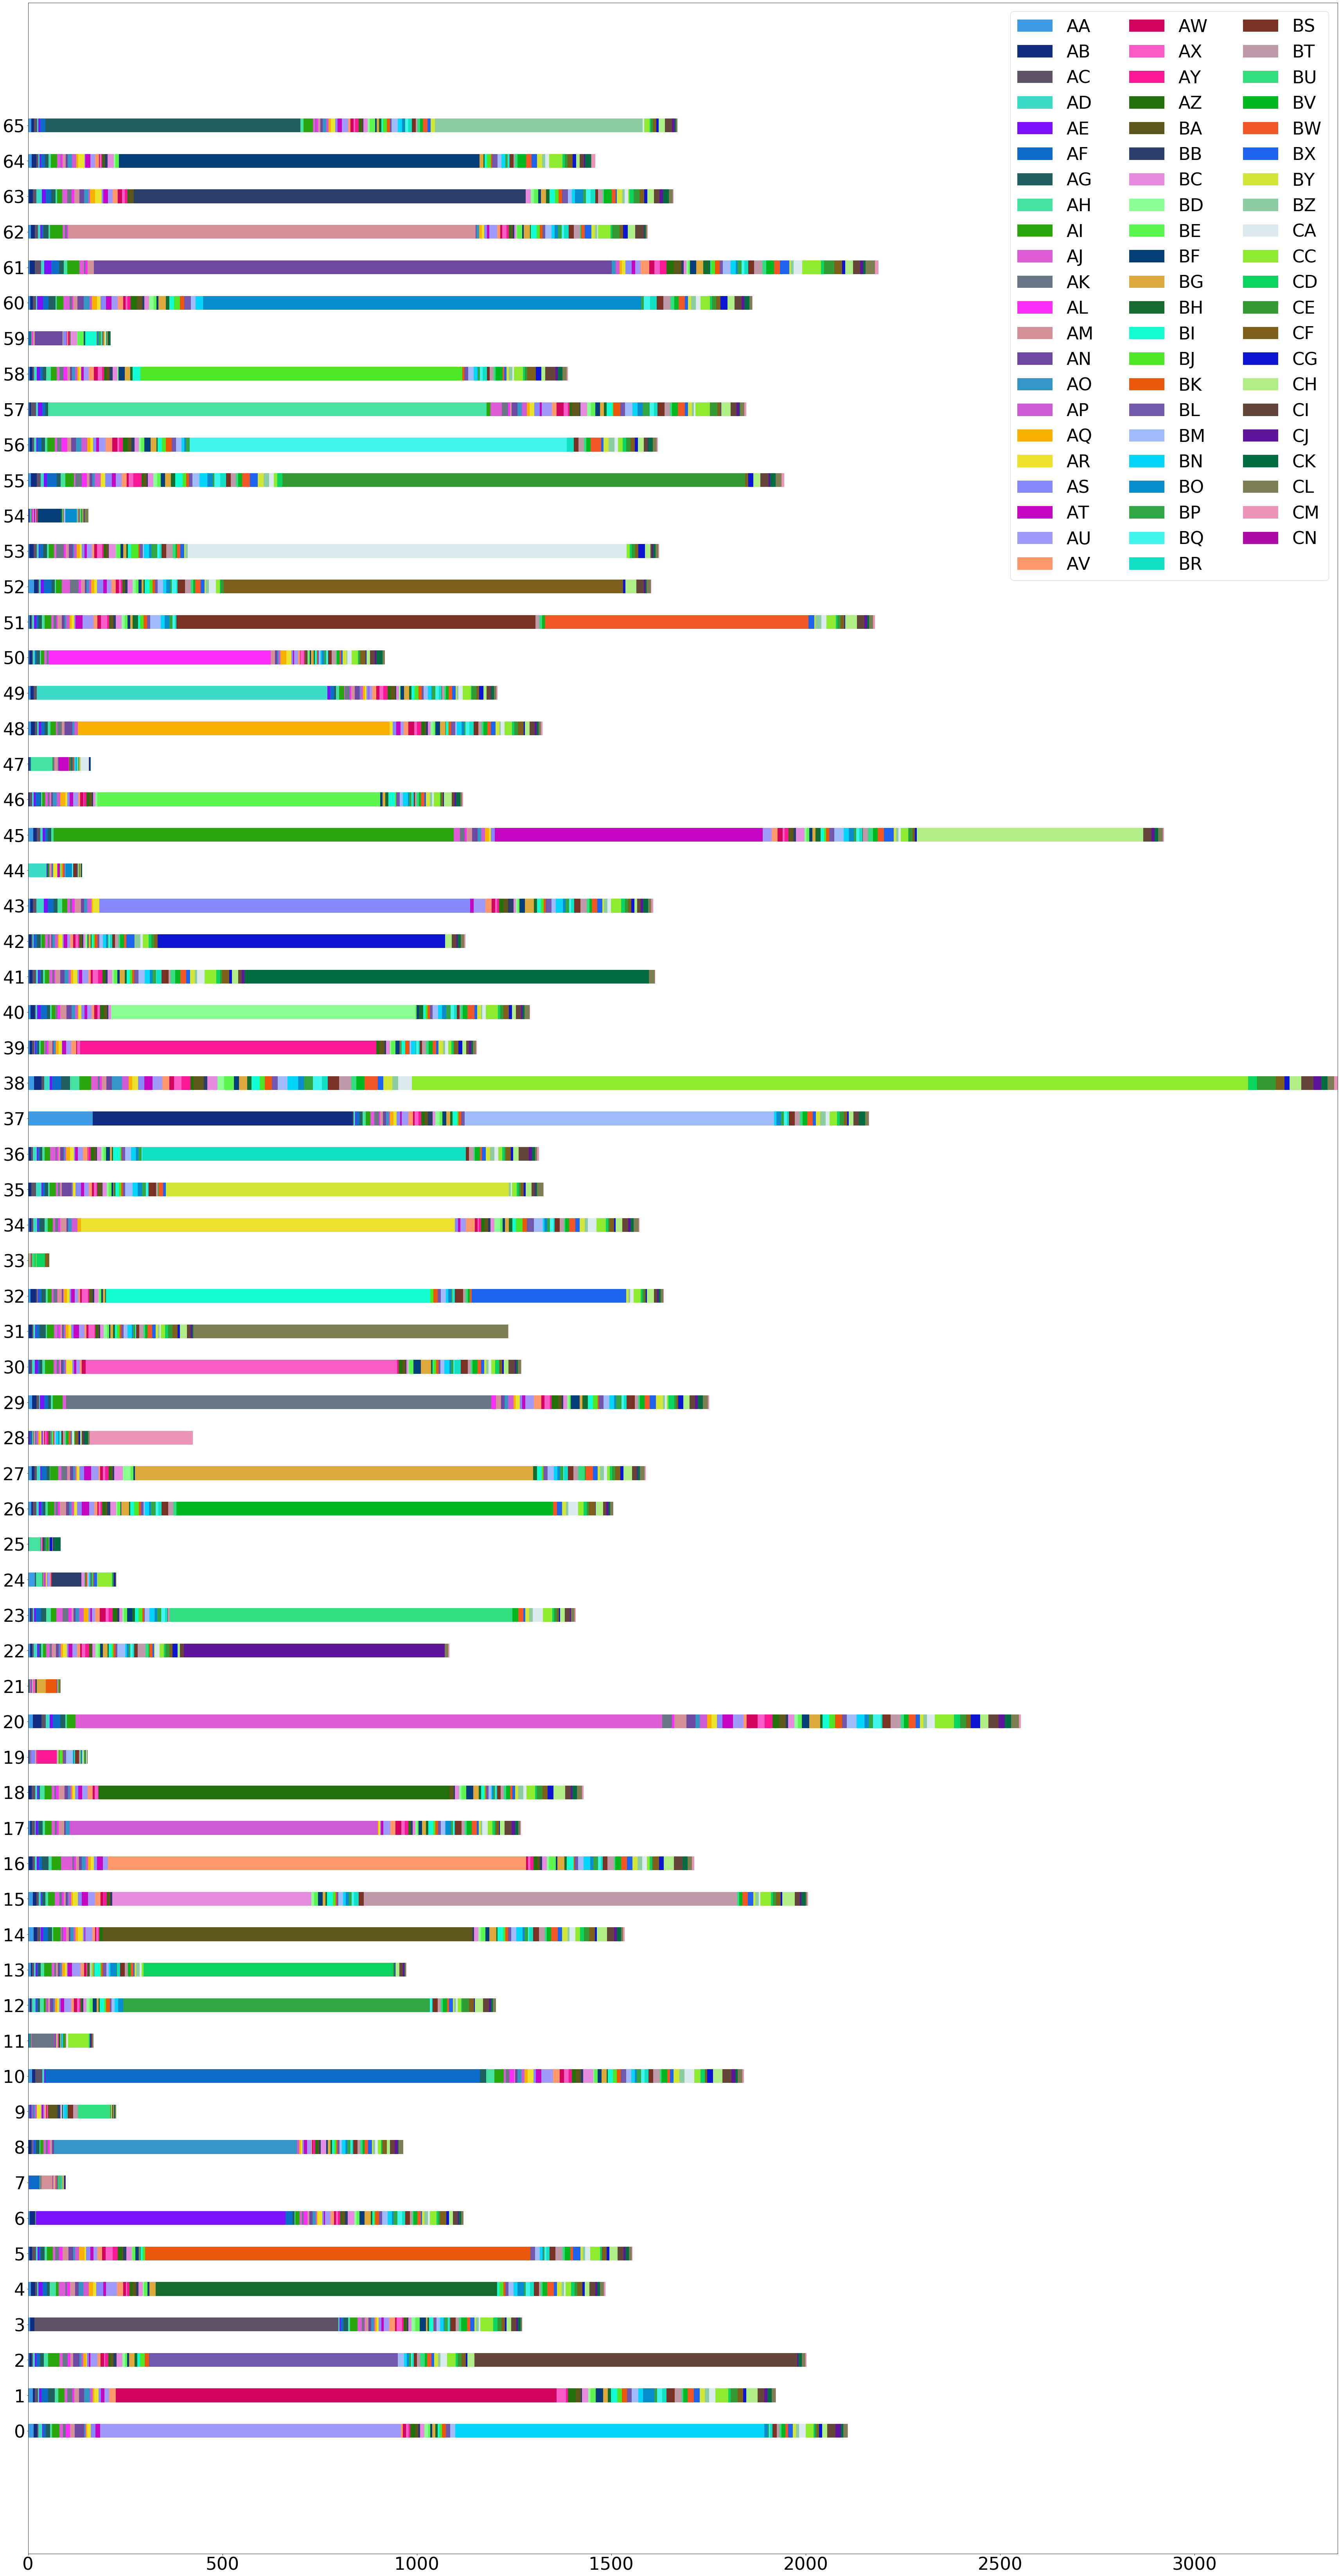

In [19]:
fig = plt.figure(figsize=(60, 120))
N = len(k)
ind = np.arange(N)*18   # the x locations for the groups
width = 7       # the width of the bars: can also be len(x) sequence

p = []
p.append(plt.barh(ind, values[0], width, color=colors[0]))

for i in range(1,len(cols)):
    p.append(plt.barh(ind, values[i], width, color=colors[i],
                left=np.sum(values[0:i], axis=0, dtype=np.int64)))

plt.yticks(ind, [key for key in k])
plt.legend((pi[0] for pi in p), (c for c in cols), fontsize=45, ncol=3, loc='upper right')
plt.tick_params(axis='both',which='major', labelsize=45)
plt.savefig('k66-clustering-summarize.png')